In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import numpy as np
import warnings

import gymnasium as gym
from gymnasium import spaces
from scipy.optimize import minimize

from cryoenv.mqtt import SoftActorCritic, ReturnTracker, HistoryWriter, CryoWorldModel, generate_sweep, augment_pars, double_tes
%config InlineBackend.figure_formats = ['png']

In [2]:
np.random.seed(8)
torch.cuda.is_available()
# warnings.simplefilter('ignore')
# gym.logger.set_level(40)

False

In [3]:
class ToyParameterEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    NMBR_STATES = 1
    NMBR_ACTIONS = NMBR_STATES

    def __init__(self, a, b):
        super(ToyParameterEnv, self).__init__()
        self.action_space = spaces.Box(low=- np.ones(self.NMBR_STATES),
                                       high=np.ones(self.NMBR_STATES))
        self.observation_space = spaces.Box(low=- np.ones(self.NMBR_STATES),
                                       high=np.ones(self.NMBR_STATES))
        self.state = np.random.uniform(-1,1,size=self.NMBR_STATES)
        assert b > a, ''
        self.a = a
        self.b = b
        
    def loss(self, x):
        loss = (self.b - self.a) - np.heaviside(x - self.a, 0) * np.heaviside(self.b - x, 0) * (x-self.a)  # (-x+self.b)
        return loss
        
    def step(self, action):
        
        info = {}
        
        new_state = action
        reward = - np.sum(self.loss(new_state))
        terminated = False
        truncated = False
        
        self.state = new_state
        
        return new_state, reward, terminated, truncated, info
    
    def reset(self, state=None):
        info = {}
        if state is None:
            self.state = np.random.uniform(-1,1,size=self.NMBR_STATES)
        else:
            self.state = state
        
        return self.state, info
        
    def render(self, show=True):
        x = np.linspace(-1, 1, 500)
        y = - self.loss(x)

        plt.plot(x,y, color='black')
        plt.scatter(self.state[0], - self.loss(self.state[0]), color='red', s=100)
        plt.xlabel('state')
        plt.ylabel('reward')
        if show:
            plt.show()

In [4]:
env = ToyParameterEnv(0.2, 0.7)

/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [5]:
state, info = env.reset()

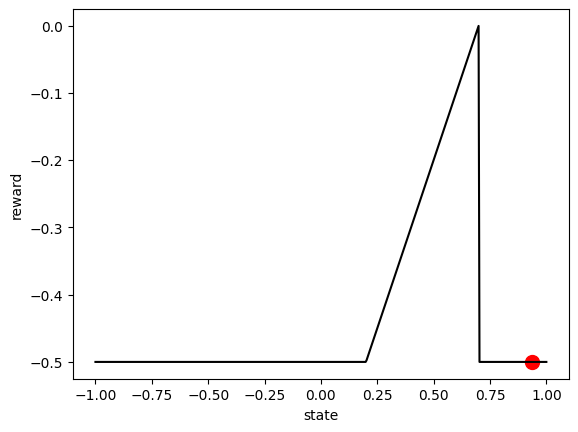

In [6]:
env.render()

# plot of failed convergence

In [7]:
model = SoftActorCritic(env, policy = "GaussianPolicy", critic = "QNetwork", lr=.0003, buffer_size=1300, learning_starts=0,
                        batch_size=16, gamma=.6, gradient_steps=100, grad_clipping=.5, tau=0.005, 
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        #temperature=0.001,
                        #entropy_tuning=False,
                        target_entropy_reduction=1.,
                       )

/Users/felix/PycharmProjects/cryoenv/cryoenv/mqtt/_sac.py:325: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_alpha = torch.tensor(torch.log(self.alpha), requires_grad=True, device=self.device)


In [8]:
tracker = ReturnTracker()
writer = HistoryWriter()

In [9]:
model.learn(episodes = 5, 
            episode_steps = 60, 
            two_pbars=True,
            tracker=tracker,
            writer=writer)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

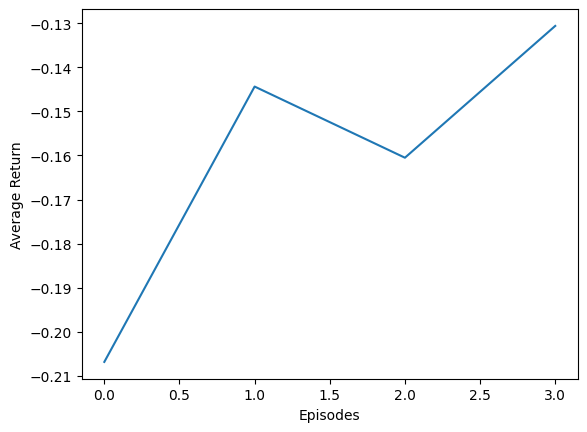

In [10]:
tracker.plot(smooth=1)

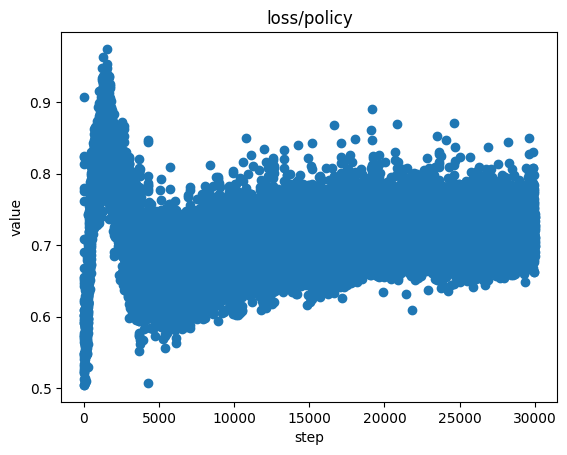

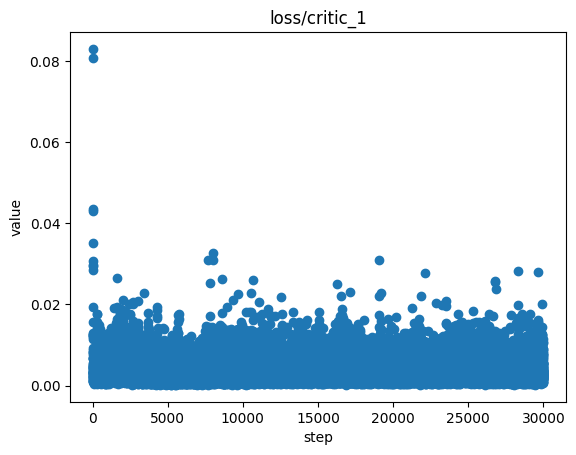

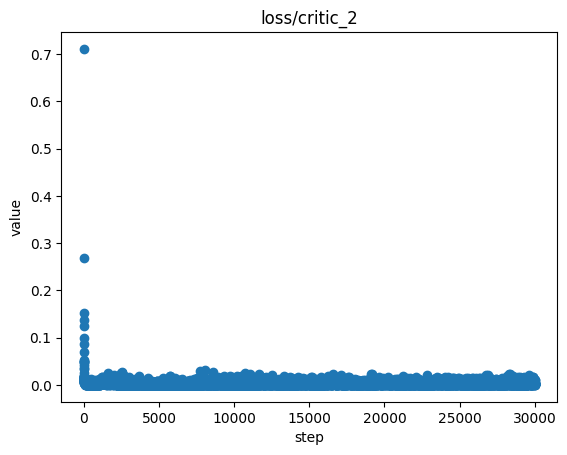

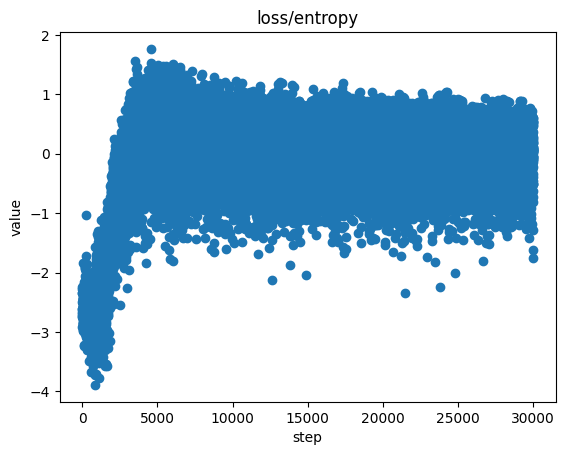

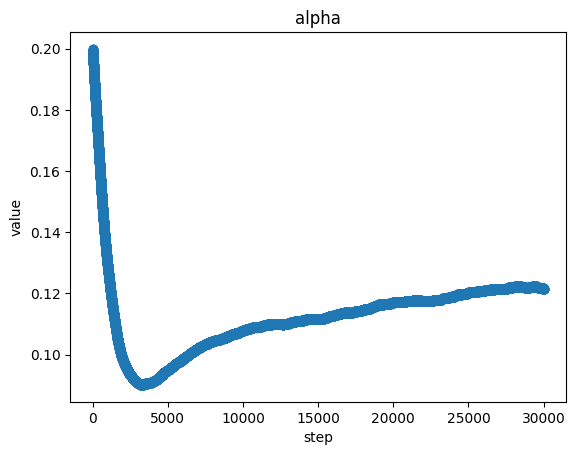

In [11]:
for key in writer.history.keys():
    writer.plot(key)

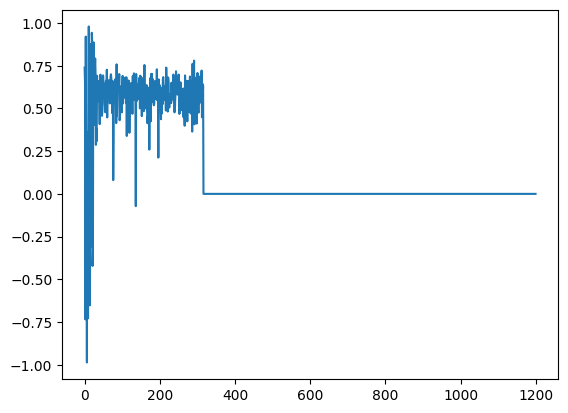

In [12]:
plt.plot(model.buffer.state_memory[:1200,0])

In [13]:
def gauss(x, mu, sigma):
    return 1 / sigma / np.sqrt(2*np.pi) * np.exp(- 1 / 2 * ( ( x - mu ) / sigma) ** 2)

In [14]:
def tanhgauss(y, mu=0, sigma=1):
    retv = np.exp( - ( ( np.arctanh(y) - mu ) / sigma ) ** 2 / 2 ) / sigma / np.sqrt(2*np.pi) / np.abs(1 - y ** 2)
    return retv

In [15]:
def logtanhgauss(y, mu=0, sigma=1):
    retv =  - ( ( np.arctanh(y) - mu ) / sigma ) ** 2 / 2 - np.log(sigma) - np.log(np.sqrt(2*np.pi)) - np.log(np.abs(1 - y ** 2))
    return retv

  0%|          | 0/5 [00:00<?, ?it/s]

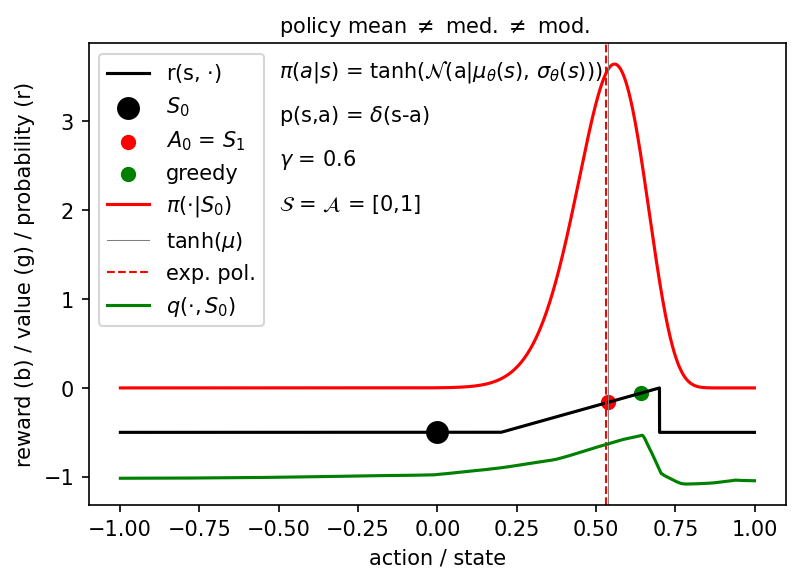

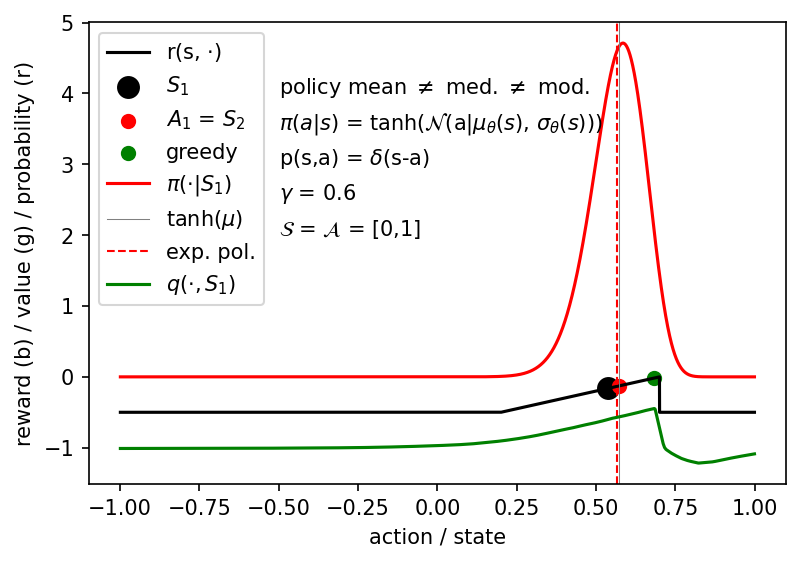

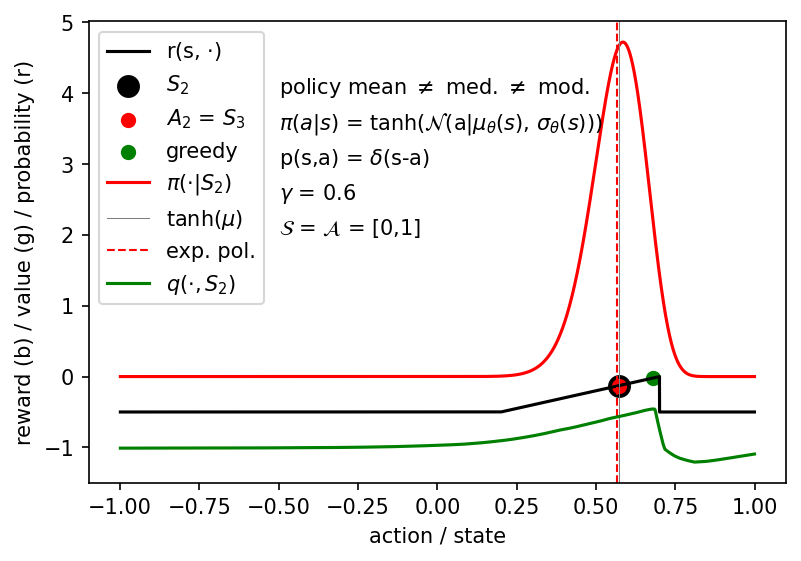

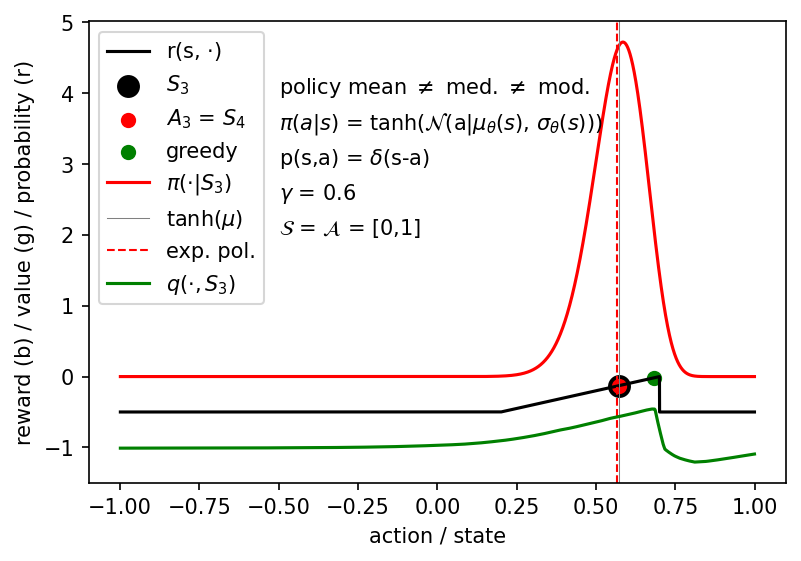

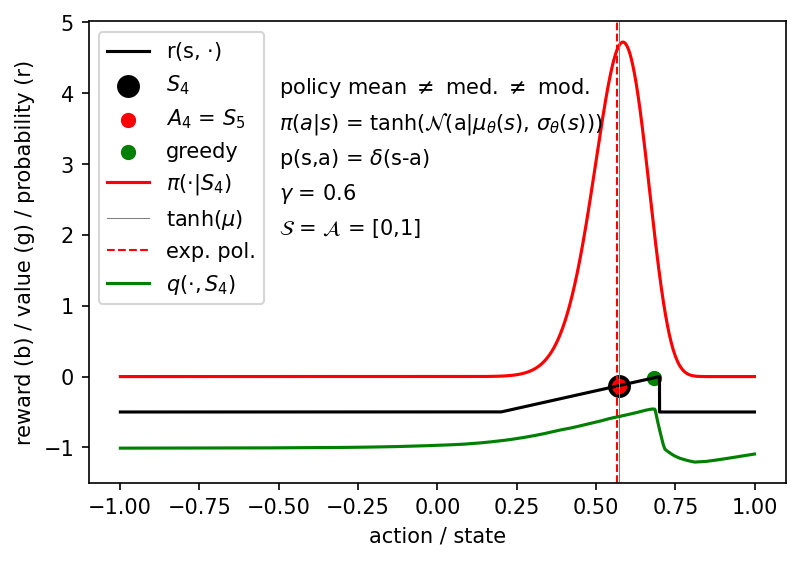

In [17]:
obs, _ = env.reset(state=np.array([0.]))
model.policy.eval()
returns = 0
grid = np.linspace(-.999,.999,5000)

for i in trange(5):
    
    env_state = env.state[0]
    
    greedy_action = model.critic.greedy(obs)
    
    action, _ = model.predict(obs, greedy=True) 
    mu, log_std = model.policy(torch.from_numpy(obs).reshape(1,-1).float())
    mu = mu.detach().cpu().numpy().flatten()
    std = log_std.exp().detach().cpu().numpy().flatten()
    
    values1, values2 = model.critic(torch.from_numpy(np.repeat(obs, grid.shape[0]).reshape(-1,1)).float(), 
             torch.from_numpy(grid.reshape(-1,1)).float())
    values = np.minimum(values1.detach().cpu().numpy(), values2.detach().cpu().numpy()).flatten()
    
    # new step
    obs, reward, terminated, truncated, info = env.step(action.flatten())
    returns += reward
    
    # plot
    plt.figure(figsize=(6,4), dpi=150)
    
    rewards = - env.loss(grid)

    plt.plot(grid, rewards, color='black', label='r(s, $\cdot$)')
    plt.scatter(env_state, - env.loss(env_state), color='black', s=100, label='$S_{}$'.format(i))
    plt.scatter(action, - env.loss(action), color='red', s=40, label='$A_{}$ = $S_{}$'.format(i, i+1))
    
    normal_probs = gauss(grid, mu, std)
    tanh_probs = tanhgauss(grid, mu, std)
    expected_value = np.trapz(tanh_probs * grid, grid)
    
    plt.scatter(greedy_action, - env.loss(greedy_action), color='green', s=40, label='greedy')
    
    # plt.plot(grid, normal_probs, color='grey')
    plt.plot(grid, tanh_probs, color='red', label='$\pi(\cdot | S_{})$'.format(i))
    plt.axvline(action, color='grey', linewidth=.5, linestyle='solid', label='tanh($\mu$)')
    plt.axvline(expected_value, color='red', linewidth=1, linestyle='dashed', label='exp. pol.')
    
    plt.plot(grid, values, color='green', label='$q(\cdot, S_{})$'.format(i))
    plt.xlabel('action / state')
    plt.ylabel('reward (b) / value (g) / probability (r)')
    
    plt.text(-.5, 2.5, '$\gamma$ = 0.6')
    plt.text(-.5, 2., '$\mathcal{S}$ = $\mathcal{A}$ = [0,1]')
    plt.text(-.5, 3., 'p(s,a) = $\delta$(s-a)')
    plt.text(-.5, 4, r'policy mean $\neq$ med. $\neq$ mod.')
    plt.text(-.5, 3.5, r'$\pi(a|s)$ = tanh($\mathcal{N}$(a|$\mu_{\theta}(s)$, $\sigma_{\theta}(s)$))')
    
    plt.legend()
    plt.savefig('plots_paper/issue_with_sac{}.png'.format(i))
    plt.show()
    
    if terminated or truncated:
        obs, _ = env.reset()

# plot of successful convergence

In [18]:
model = SoftActorCritic(env, policy = "GaussianPolicy", critic = "QNetwork", lr=.0003, buffer_size=1300, learning_starts=0,
                        batch_size=16, gamma=.6, gradient_steps=100, grad_clipping=.5, tau=0.005, 
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        #temperature=0.001,
                        #entropy_tuning=False,
                        target_entropy_reduction=.9999,
                       )

In [19]:
tracker = ReturnTracker()
writer = HistoryWriter()

In [20]:
model.learn(episodes = 5, 
            episode_steps = 60, 
            two_pbars=True,
            tracker=tracker,
            writer=writer)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

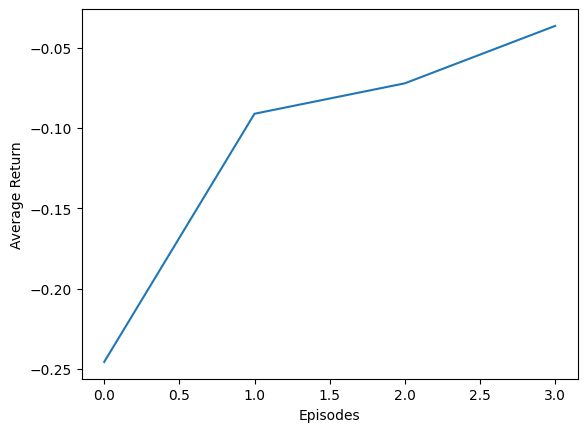

In [21]:
tracker.plot(smooth=1)

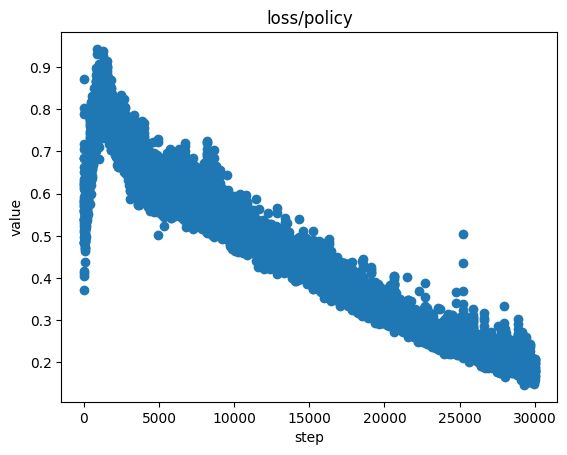

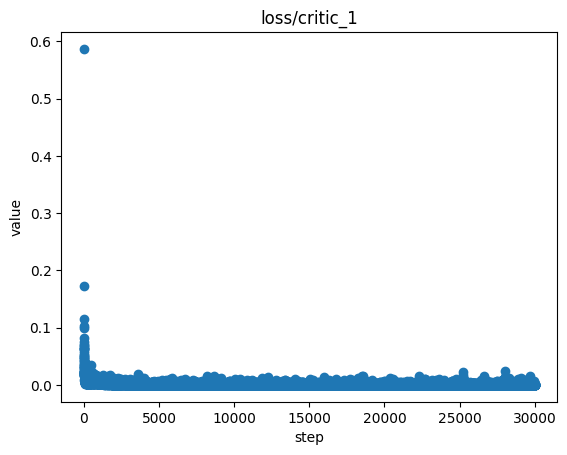

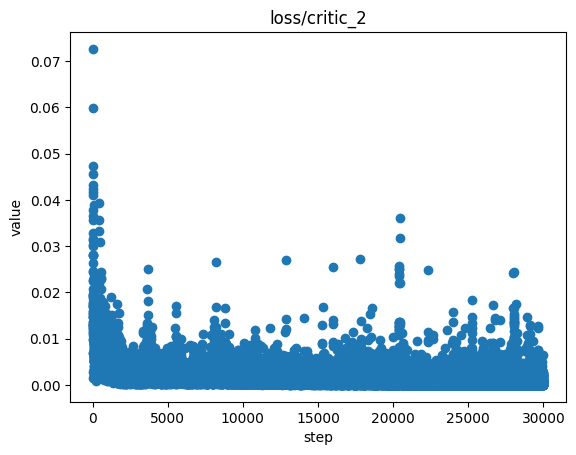

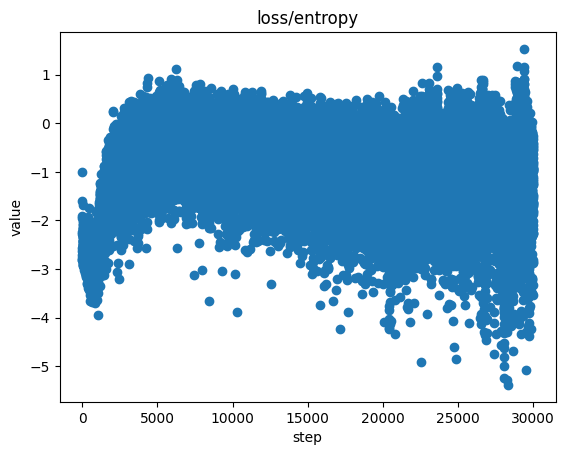

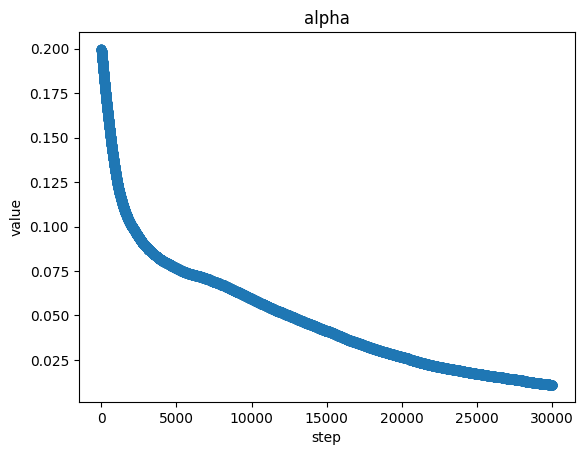

In [22]:
for key in writer.history.keys():
    writer.plot(key)

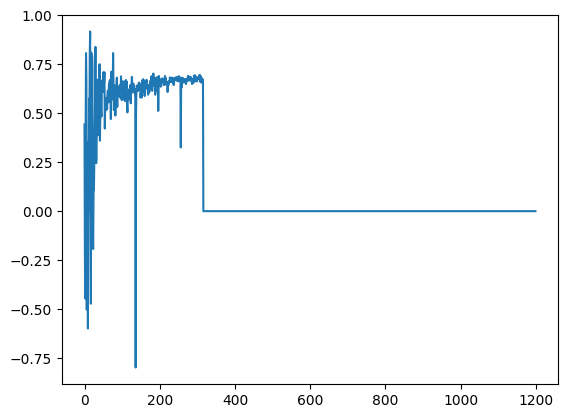

In [23]:
plt.plot(model.buffer.state_memory[:1200,0])

  0%|          | 0/5 [00:00<?, ?it/s]

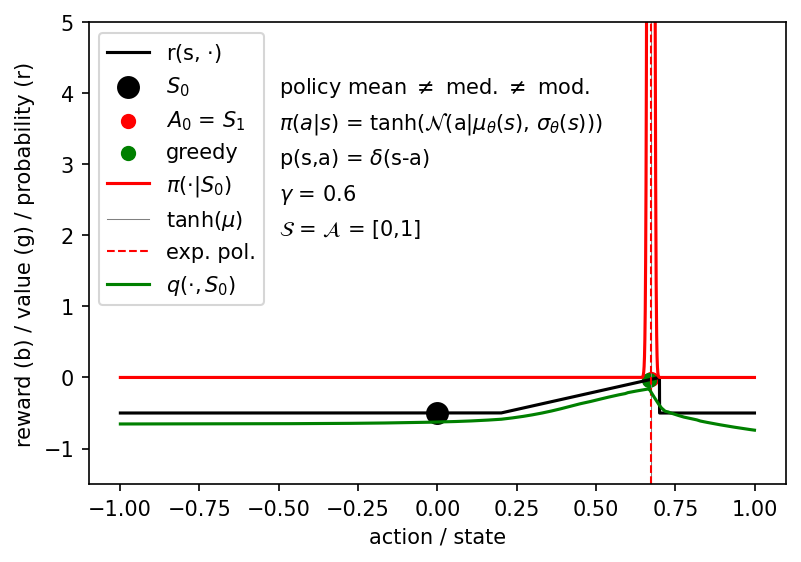

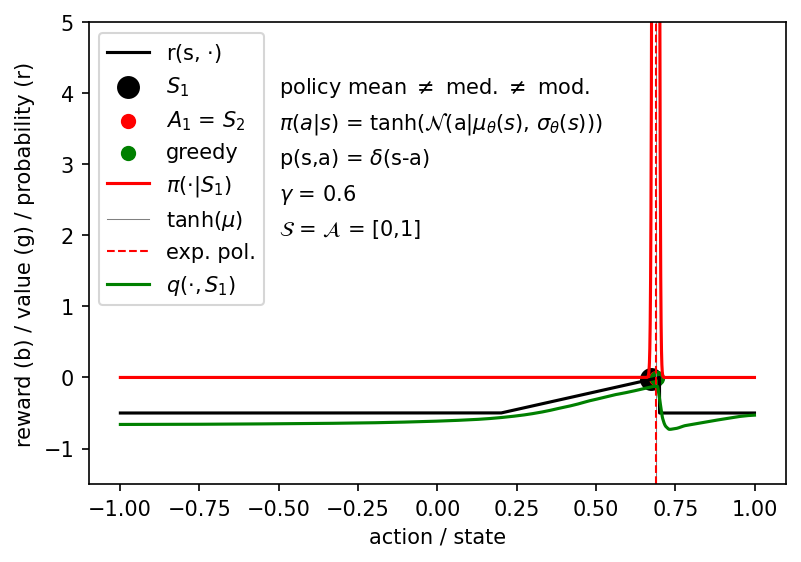

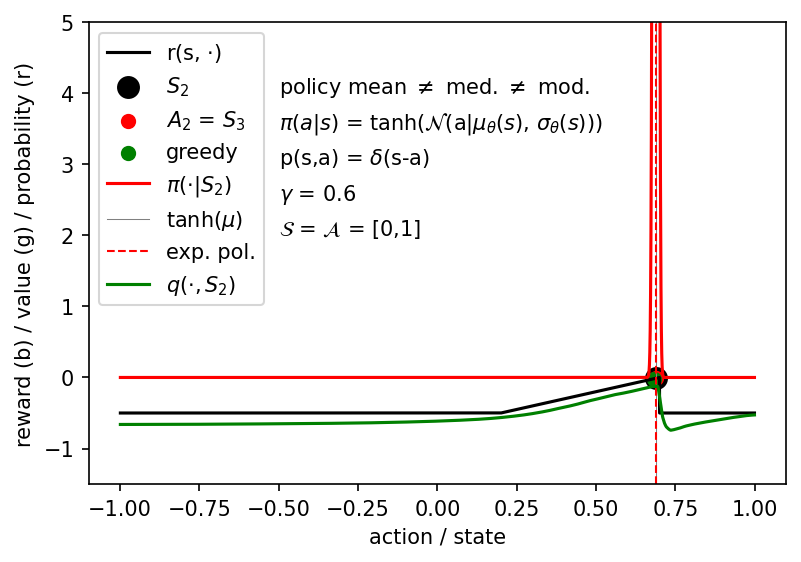

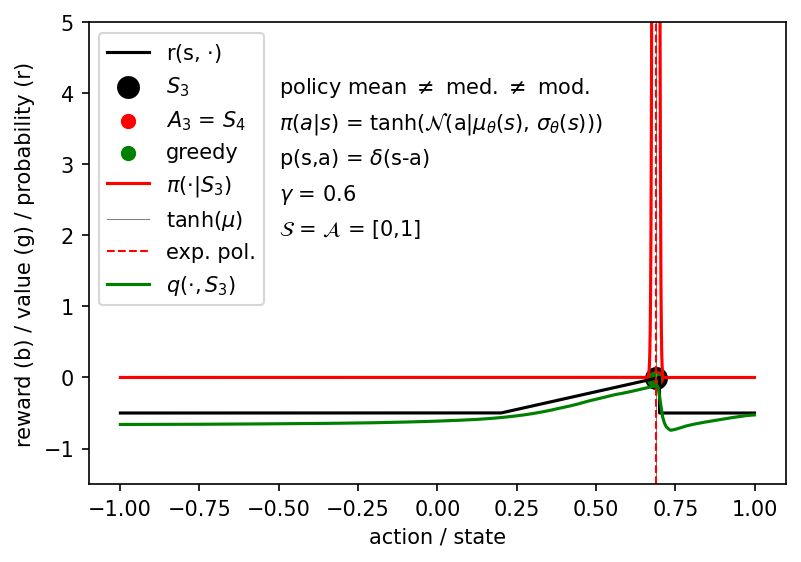

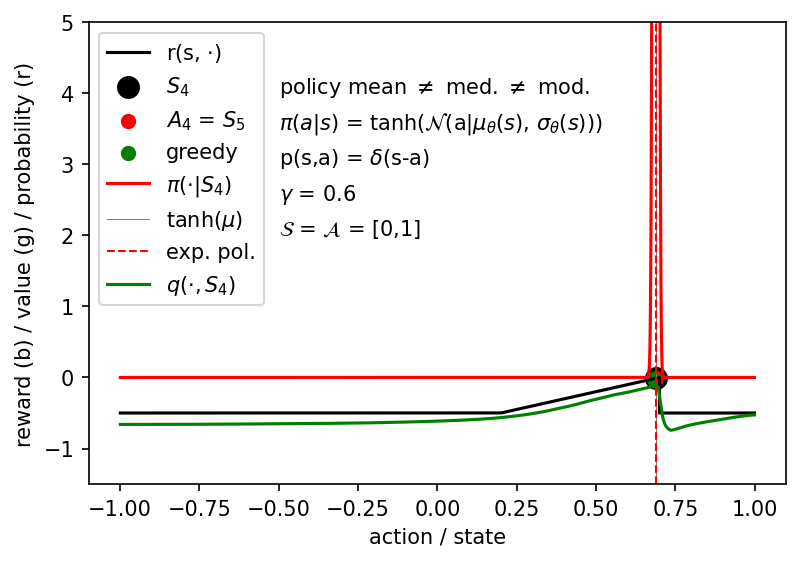

In [24]:
# TODO make this plot nicer

obs, _ = env.reset(state=np.array([0.]))
model.policy.eval()
returns = 0
grid = np.linspace(-.999,.999,5000)

for i in trange(5):
    
    env_state = env.state[0]
    
    greedy_action = model.critic.greedy(obs)
    
    action, _ = model.predict(obs, greedy=True) 
    mu, log_std = model.policy(torch.from_numpy(obs).reshape(1,-1).float())
    mu = mu.detach().cpu().numpy().flatten()
    std = log_std.exp().detach().cpu().numpy().flatten()
    
    values1, values2 = model.critic(torch.from_numpy(np.repeat(obs, grid.shape[0]).reshape(-1,1)).float(), 
             torch.from_numpy(grid.reshape(-1,1)).float())
    values = np.minimum(values1.detach().cpu().numpy(), values2.detach().cpu().numpy()).flatten()
    
    # new step
    obs, reward, terminated, truncated, info = env.step(action.flatten())
    returns += reward
    
    # plot
    plt.figure(figsize=(6,4), dpi=150)
    
    rewards = - env.loss(grid)

    plt.plot(grid, rewards, color='black', label='r(s, $\cdot$)')
    plt.scatter(env_state, - env.loss(env_state), color='black', s=100, label='$S_{}$'.format(i))
    plt.scatter(action, - env.loss(action), color='red', s=40, label='$A_{}$ = $S_{}$'.format(i, i+1))
    
    normal_probs = gauss(grid, mu, std)
    tanh_probs = tanhgauss(grid, mu, std)
    expected_value = np.trapz(tanh_probs * grid, grid)
    
    plt.scatter(greedy_action, - env.loss(greedy_action), color='green', s=40, label='greedy')
    
    # plt.plot(grid, normal_probs, color='grey')
    plt.plot(grid, tanh_probs, color='red', label='$\pi(\cdot | S_{})$'.format(i))
    plt.axvline(action, color='grey', linewidth=.5, linestyle='solid', label='tanh($\mu$)')
    plt.axvline(expected_value, color='red', linewidth=1, linestyle='dashed', label='exp. pol.')
    
    plt.plot(grid, values, color='green', label='$q(\cdot, S_{})$'.format(i))
    plt.xlabel('action / state')
    plt.ylabel('reward (b) / value (g) / probability (r)')
    
    plt.text(-.5, 2.5, '$\gamma$ = 0.6')
    plt.text(-.5, 2., '$\mathcal{S}$ = $\mathcal{A}$ = [0,1]')
    plt.text(-.5, 3., 'p(s,a) = $\delta$(s-a)')
    plt.text(-.5, 4, r'policy mean $\neq$ med. $\neq$ mod.')
    plt.text(-.5, 3.5, r'$\pi(a|s)$ = tanh($\mathcal{N}$(a|$\mu_{\theta}(s)$, $\sigma_{\theta}(s)$))')
    
    plt.ylim(-1.5,5)
    plt.legend()
    plt.savefig('plots_paper/issue_with_sac_solved{}.png'.format(i))
    plt.show()
    
    if terminated or truncated:
        obs, _ = env.reset()

# this is how the tanhgauss distribution looks like

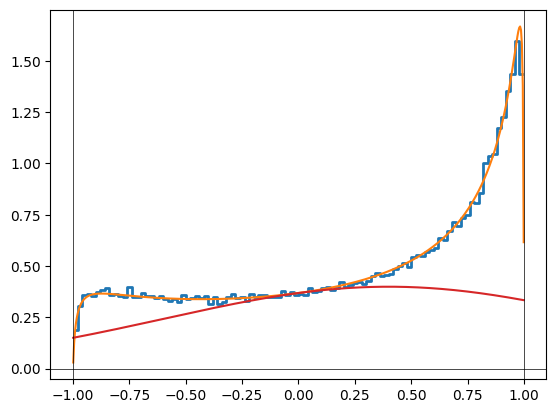

In [119]:
mu = 0.4
sigma = 1
randvars = np.random.normal(mu, sigma, size=100000)
randvars = np.tanh(randvars)

hist, bins = np.histogram(randvars, bins=100)
bw = (bins[1] - bins[0])
bin_centers = bins[:-1] + bw/2
hist = hist / bw / 100000

plt.step(bin_centers, hist, linewidth=2, where='mid', color='C0')

grid = np.linspace(-.999, .999, 500)
plt.plot(grid, tanhgauss(grid, mu=mu, sigma=sigma), color='C1')  
# plt.plot(grid, logtanhgauss(grid, mu=mu, sigma=sigma), color='C2')  
plt.plot(grid, gauss(grid, mu=mu, sigma=sigma), color='C3')

plt.xlim(-1.1,1.1)
plt.axvline(-1, color='black', linewidth=0.5)
plt.axvline(1, color='black', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

# calc some examples of tanhgauss entropies

In [143]:
xlist = np.linspace(-2,2,50)
ylist = np.linspace(.1,.6,40)
entropies = np.zeros((xlist.shape[0],ylist.shape[0]))
expectations = np.zeros((xlist.shape[0],ylist.shape[0]))
standarddevs = np.zeros((xlist.shape[0],ylist.shape[0]))

def get_metrics(mu,sigma):
    p = tanhgauss(grid, mu=mu, sigma=sigma)
    exp = np.trapz(grid, grid*p)
    var = np.trapz(grid, (p - exp) ** 2 * p)
    
    h = np.copy(p)
    h[h==0] = 1
    h *= np.log(h)
    h = np.trapz(grid, - h) 
    return exp, var, h

for i,mu in enumerate(xlist):
    for j,sigma in enumerate(ylist):
        exp, var, h = get_metrics(mu,sigma)
        expectations[i,j] = exp
        standarddevs[i,j] = var
        entropies[i,j] = h

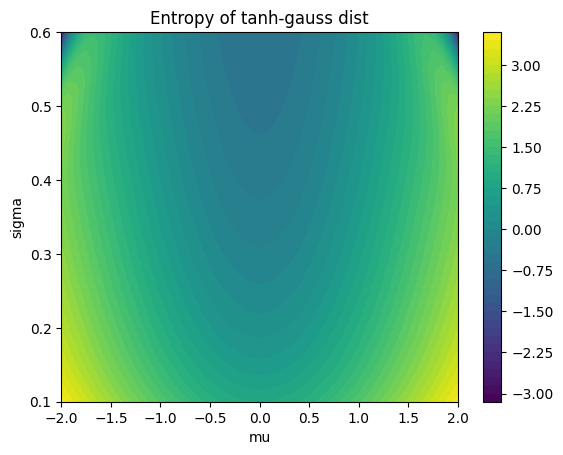

In [144]:
X, Y = np.meshgrid(xlist, ylist)

plt.figure(dpi=100)
plt.contourf(X,Y,entropies.T, levels=50)
plt.colorbar()
plt.ylabel('sigma')
plt.xlabel('mu')
plt.title('Entropy of tanh-gauss dist')
plt.show()

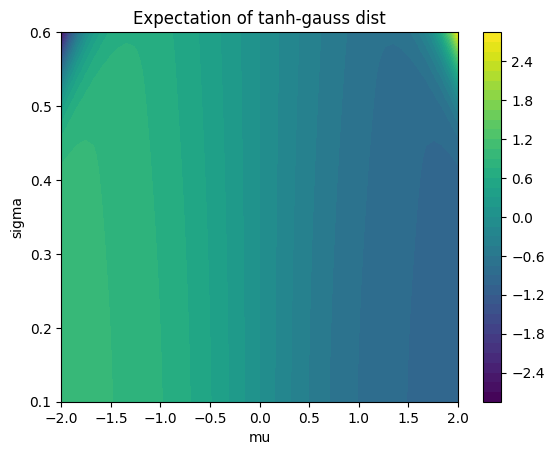

In [145]:
X, Y = np.meshgrid(xlist, ylist)

plt.figure(dpi=100)
plt.contourf(X,Y,expectations.T, levels=50)
plt.colorbar()
plt.ylabel('sigma')
plt.xlabel('mu')
plt.title('Expectation of tanh-gauss dist')
plt.show()

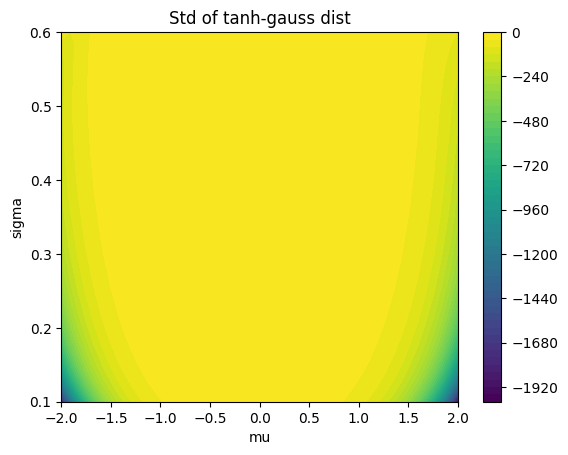

In [146]:
X, Y = np.meshgrid(xlist, ylist)

plt.figure(dpi=100)
plt.contourf(X,Y,standarddevs.T, levels=50)
plt.colorbar()
plt.ylabel('sigma')
plt.xlabel('mu')
plt.title('Std of tanh-gauss dist')
plt.show()